In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller Aumentado para estacionariedad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [52]:
df = pd.read_csv('./data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [54]:
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [55]:
df = df.set_index(df['Month'])
df = df.rename(columns = {'#Passengers': 'People'})
df.drop(['Month'], axis = 1, inplace = True)
df.head()

,People
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#Visual Inspection

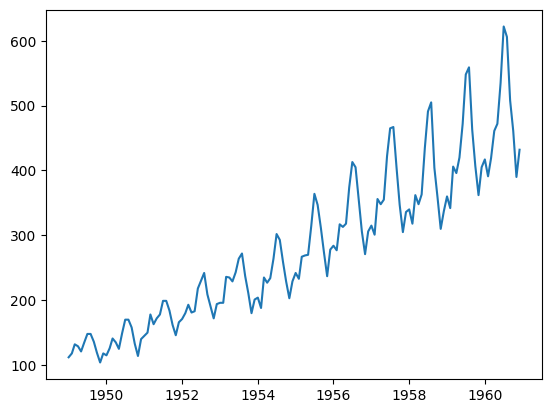

In [56]:
plt.plot(df.index, df.People)

#Clearly an upward trend with clear stationality

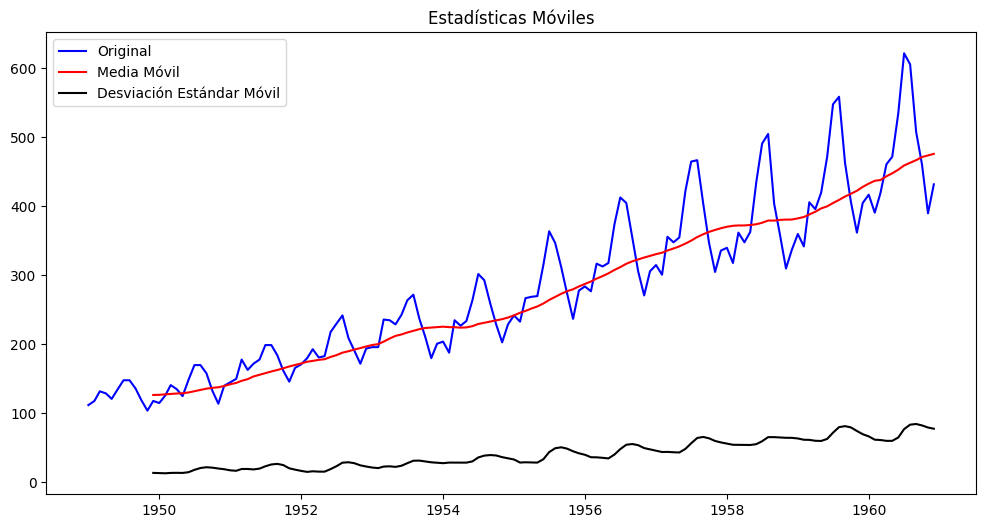


Resultados del Test de Dickey-Fuller para:
Test_stat            0.815369
p-val                0.991880
Lags_used           13.000000
N _observations    130.000000
1%                  -3.481682
5%                  -2.884042
10%                 -2.578770
dtype: float64
Resultado: La serie NO es ESTACIONARIA (no se rechaza la hipótesis nula)


In [57]:
def dickey_fuller(serie, window):

    media_mov = serie.rolling(window=window).mean()
    std_mov = serie.rolling(window = window).std()
    plt.figure(figsize=(12, 6))
    plt.plot(serie, color='blue',label='Original')
    plt.plot(media_mov, color='red', label='Media Móvil')
    plt.plot(std_mov, color='black', label = 'Desviación Estándar Móvil')
    plt.legend(loc='best')
    plt.title('Estadísticas Móviles')
    plt.show()

    #Test como tal
    print(f'\nResultados del Test de Dickey-Fuller para:')
    dftest = adfuller(serie.dropna(), autolag='AIC')
    df_output = pd.Series(dftest[:4], index = ['Test_stat', 'p-val', 'Lags_used', 'N _observations'])
    for k, v in dftest[4].items():
        df_output[k] = v
    print(df_output)
    if dftest[1] < 0.05:
        print("Resultado: La serie es ESTACIONARIA (se rechaza la hipótesis nula)")
    else:
        print("Resultado: La serie NO es ESTACIONARIA (no se rechaza la hipótesis nula)")


dickey_fuller(df.People, window=12)





La tendencia va hacia arriba y existe estacionalidad, por lo que los estadisticos varian son dependientes del tiempo en vez de la variable objetivo.

# Transformación Logaritmica de la Serie

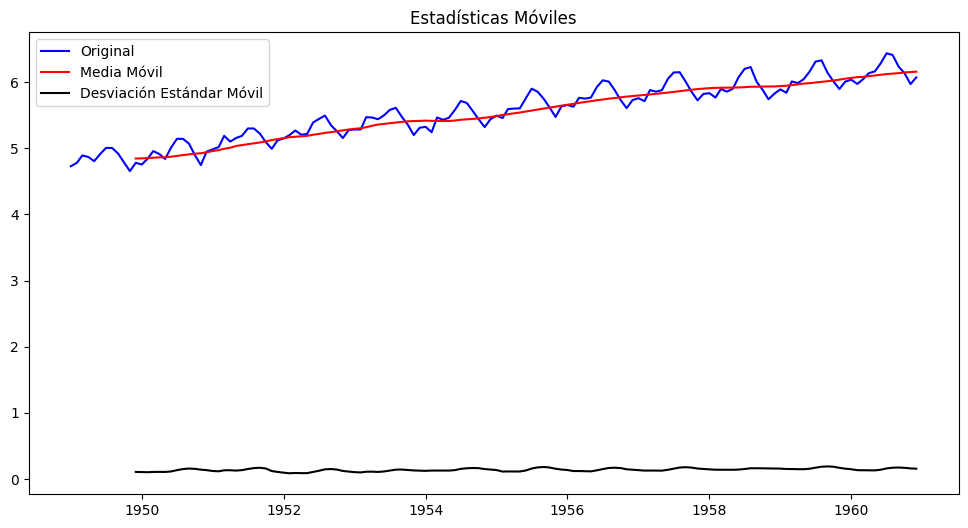


Resultados del Test de Dickey-Fuller para:
Test_stat           -1.706411
p-val                0.427813
Lags_used           13.000000
N _observations    130.000000
1%                  -3.481682
5%                  -2.884042
10%                 -2.578770
dtype: float64
Resultado: La serie NO es ESTACIONARIA (no se rechaza la hipótesis nula)


In [58]:
df_log = df.copy()
df_log['People'] = np.log1p(df_log['People'])

dickey_fuller(df_log.People, window = 12)

La variación bajo demasiado, sin embargo sigue existiendo una tendencia clara y estacionalidad definidos por la salida del test

#Diferenciación

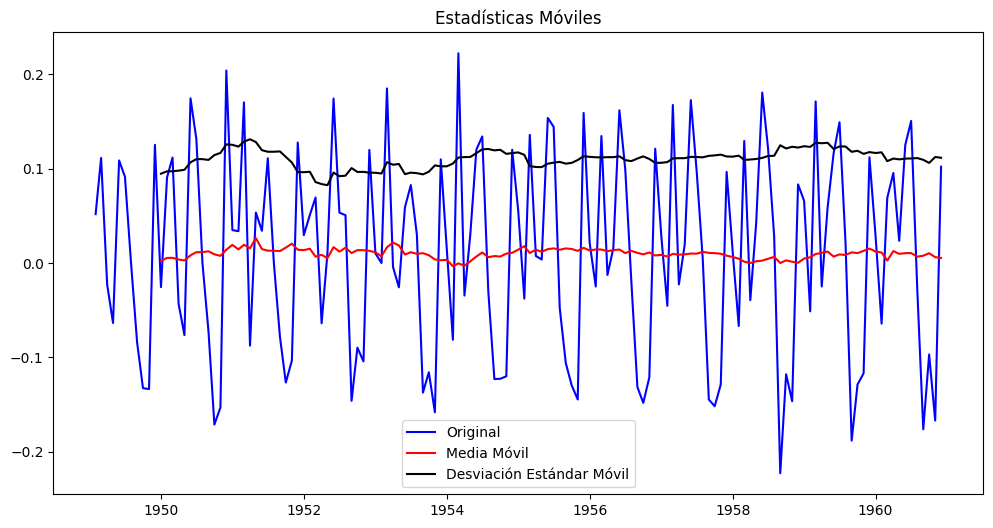


Resultados del Test de Dickey-Fuller para:
Test_stat           -2.721947
p-val                0.070317
Lags_used           14.000000
N _observations    128.000000
1%                  -3.482501
5%                  -2.884398
10%                 -2.578960
dtype: float64
Resultado: La serie NO es ESTACIONARIA (no se rechaza la hipótesis nula)


In [59]:
df_diffed = df_log.copy()
df_diffed['People'] = df_diffed['People'].diff(1)
dickey_fuller(df_diffed.People, window = 12)

# Una sola diferenciación no fue lo suficiente para poder eliminar la estacionalidad de la serie....
¿Qué hacer?

Hacer una diferenciación a nivel de estacionalidad despues de haber aplicado la diferenciación regular

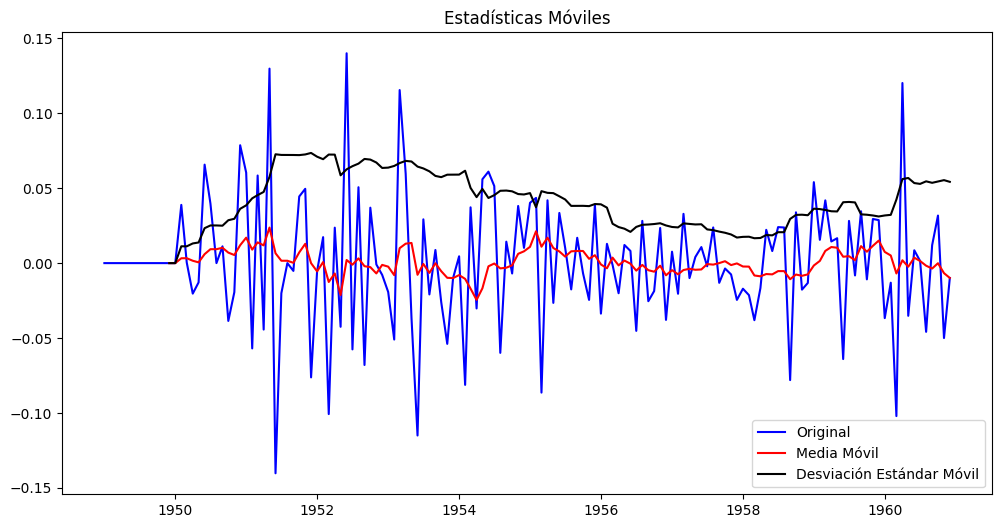


Resultados del Test de Dickey-Fuller para:
Test_stat           -3.993911
p-val                0.001443
Lags_used           11.000000
N _observations    132.000000
1%                  -3.480888
5%                  -2.883697
10%                 -2.578586
dtype: float64
Resultado: La serie es ESTACIONARIA (se rechaza la hipótesis nula)


In [60]:
df_diffed_season = df_diffed.copy()
df_diffed_season['People'] = df_diffed_season['People'].diff(12)
df_diffed_season.fillna(0, inplace = True)
dickey_fuller(df_diffed_season.People, window = 12)

# Una vez la serie es estacionaria podemos aplicar modelos

In [61]:
train_size = int(len(df_diffed_season) * 0.8) #lim_sup
train_df = df_diffed_season[:train_size]
test_df = df_diffed_season[train_size:]

In [62]:
def invert_transformations_corrected(
    y_transformed_pred_array, # Array de numpy con predicciones transformadas
    y_transformed_true_array, # Array de numpy con verdaderos transformados
    prediction_datetime_index, # pd.Index para estas predicciones/verdaderos
    original_full_log_series, # Serie pd: np.log1p(df_original['People']) con índice datetime original
    original_full_log_diff1_series, # Serie pd: np.log1p(df_original['People']).diff(1) con índice datetime original
    seasonal_lag=12
):
    """
    Invierte las transformaciones en este orden: log1p, diff(1), diff(seasonal_lag).
    """
    # Hacer series para usar paralelismo con los indices
    s_pred_transformed = pd.Series(y_transformed_pred_array, index=prediction_datetime_index)
    s_true_transformed = pd.Series(y_transformed_true_array, index=prediction_datetime_index)

    # Paso 1: Invertir diferenciación estacional (w_t = d_t - d_{t-L} => d_t = w_t + d_{t-L})
    s_pred_log_diff1 = s_pred_transformed + original_full_log_diff1_series.shift(seasonal_lag).loc[prediction_datetime_index]
    s_true_log_diff1 = s_true_transformed + original_full_log_diff1_series.shift(seasonal_lag).loc[prediction_datetime_index]

    # Paso 2: Invertir diferenciación regular (d_t = l_t - l_{t-1} => l_t = d_t + l_{t-1})
    # Sumamos el valor de la serie (solo log) del período anterior.
    s_pred_log = s_pred_log_diff1 + original_full_log_series.shift(1).loc[prediction_datetime_index]
    s_true_log = s_true_log_diff1 + original_full_log_series.shift(1).loc[prediction_datetime_index]
    
    # Paso 3: Deshacer log1p
    pred_original = np.expm1(s_pred_log)
    true_original_reconstructed = np.expm1(s_true_log) 

    return pred_original.values, true_original_reconstructed.values

mae en fold 1 (transformado): 0.0797
mae en fold 2 (transformado): 0.0867
mae en fold 3 (transformado): 0.0578
mae en fold 4 (transformado): 0.0384
mae en fold 5 (transformado): 0.0219

mae promedio en escala transformada: 0.0569

mae en fold 5 (escala original): 0.0219


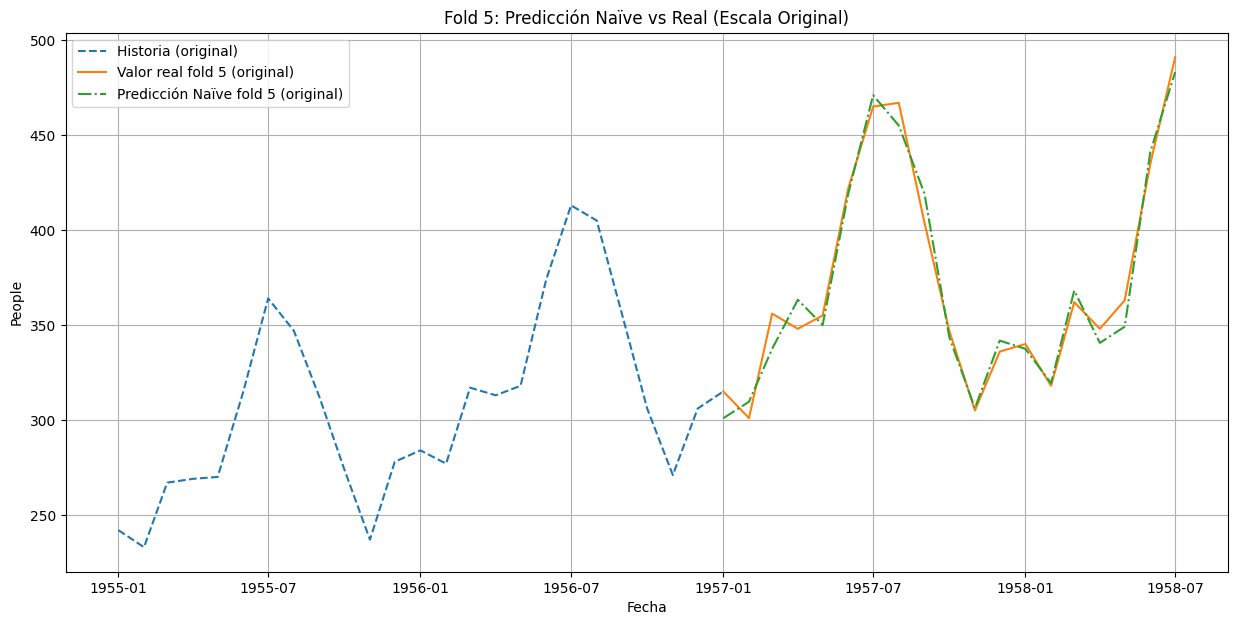

In [63]:
model_name = 'Naive'
model_scores = {}
tscv = TimeSeriesSplit(n_splits=5)
naive_approach_mae = []
fold = 0

train_prev_folds = pd.DataFrame() 
naive_preds_fold5_list = [] 
val_fold5 = None
val_fold5_true_list = [] 
best_ovr_score = 0

train_data_fold5_transformed = None 

for train_id, val_id in tscv.split(train_df): 
    fold += 1
    train, val = train_df.iloc[train_id], train_df.iloc[val_id]


    naive_preds_current_fold = []
    
    prev = train['People'].iloc[-1]
    

    for true_val_transformed in val['People']:
        pred = prev
        naive_preds_current_fold.append(pred)
        prev = true_val_transformed 

    mae = mean_absolute_error(val['People'].values, naive_preds_current_fold)
    print(f'mae en fold {fold} (transformado): {mae:.4f}')
    naive_approach_mae.append(mae)

    if fold < 5:
        train_prev_folds = pd.concat([train_prev_folds, val[['People']]])
    else: 
        naive_preds_fold5_list = naive_preds_current_fold
        val_fold5 = val.copy() # Guardamos el DataFrame de validación del fold 5
        val_fold5_true_list = val['People'].values # Guardamos los valores verdaderos transformados
        train_data_fold5_transformed = train.copy() # Guardamos el train del fold 5 para graficar


best_ovr_score = np.mean(naive_approach_mae)
model_scores[model_name] = best_ovr_score
print(f'\nmae promedio en escala transformada: {np.mean(naive_approach_mae):.4f}')


pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(naive_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],         
    original_full_log_diff1_series=df_diffed['People'], 
    seasonal_lag=12                          
)

# mae en escala original para el fold 5
mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'], # Valores originales verdaderos del fold 5
    pred_original_fold5
)
print(f'\nmae en fold 5 (escala original): {mae_original_fold5:.4f}')




plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0] 
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')

plt.plot(df.loc[val_fold5.index, 'People'], label='Valor real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción Naïve fold 5 (original)', linestyle='-.')

plt.title('Fold 5: Predicción Naïve vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()

# AHora SimpleExponentialSmoothing o Media Ponderada exponencial
El naive approach dio resultados muy buenos

mae en fold 1 (transformado): 0.0517
mae en fold 2 (transformado): 0.0832
mae en fold 3 (transformado): 0.0453
mae en fold 4 (transformado): 0.0237
mae en fold 5 (transformado): 0.0263

mae promedio en escala transformada: 0.0460
Nuevo mejor MAE

mae en fold 5 (escala original): 0.0258


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritor

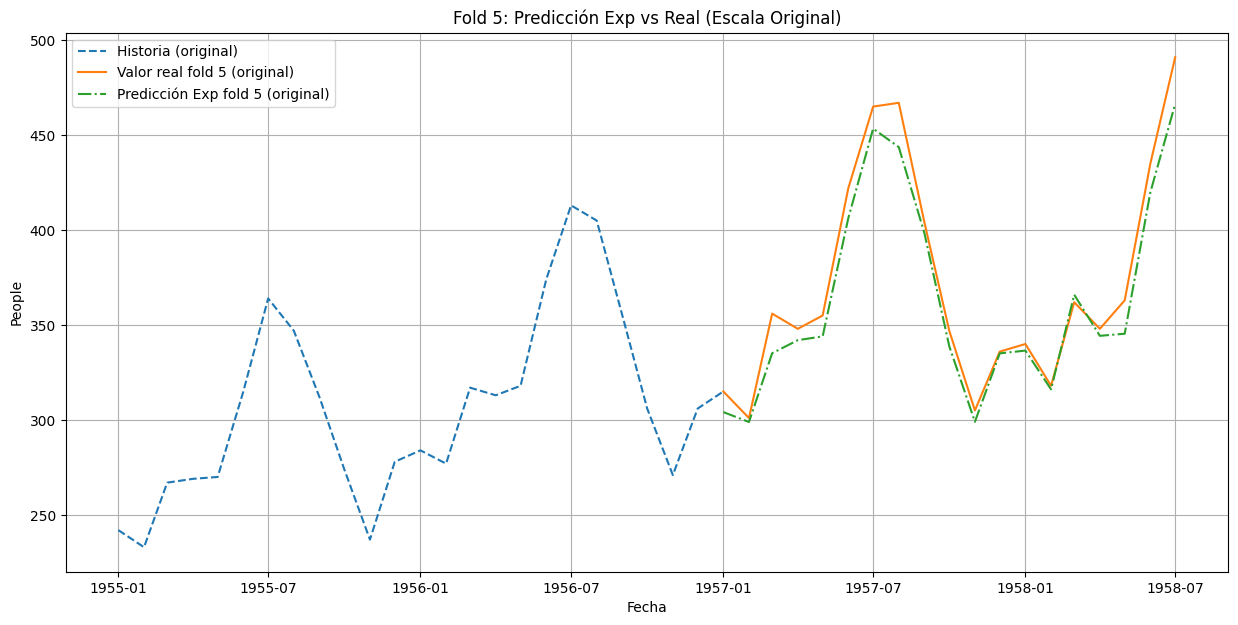

In [64]:
model_name = 'SimpleExp'
tscv = TimeSeriesSplit(n_splits=5)
exp_smooth_mae = []
fold = 0

train_prev_folds = pd.DataFrame() 
exp_preds_fold5_list = [] 
val_fold5 = None
val_fold5_true_list = [] 


train_data_fold5_transformed = None 

for train_id, val_id in tscv.split(train_df): 
    fold += 1
    train, val = train_df.iloc[train_id], train_df.iloc[val_id]


    model_exp = ExponentialSmoothing(train).fit(smoothing_level = 0.8, optimized = True)

    model_exp_preds = model_exp.forecast(len(val.index))

    mae = mean_absolute_error(val['People'].values, model_exp_preds)
    print(f'mae en fold {fold} (transformado): {mae:.4f}')
    exp_smooth_mae.append(mae)

    if fold < 5:
        train_prev_folds = pd.concat([train_prev_folds, val[['People']]])
    else: 
        exp_preds_fold5_list = model_exp_preds
        val_fold5 = val.copy() # Guardamos el DataFrame de validación del fold 5
        val_fold5_true_list = val['People'].values # Guardamos los valores verdaderos transformados
        train_data_fold5_transformed = train.copy() # Guardamos el train del fold 5 para graficar

mean_mae_exp = np.mean(exp_smooth_mae)
model_scores[model_name] = mean_mae_exp
print(f'\nmae promedio en escala transformada: {mean_mae_exp:.4f}')

if best_ovr_score > mean_mae_exp:
    best_ovr_score = mean_mae_exp
    print('Nuevo mejor MAE')

pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(exp_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],         
    original_full_log_diff1_series=df_diffed['People'], 
    seasonal_lag=12                          
)

# mae en escala original para el fold 5
mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'], # Valores originales verdaderos del fold 5
    pred_original_fold5
)
print(f'\nmae en fold 5 (escala original): {mae_original_fold5:.4f}')



plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0] 
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')

plt.plot(df.loc[val_fold5.index, 'People'], label='Valor real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción Exp fold 5 (original)', linestyle='-.')

plt.title('Fold 5: Predicción Exp vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()

# Como se aplicaría este mismo modelo pero con variables dummies?

In [65]:
#Generando Dummies para el caso de estudio

df_diffed_season_dum = df_diffed_season.copy()
df_diffed_season_dum = pd.to_datetime(df_diffed_season.index)
df_diffed_season['mes'] = df_diffed_season.index.month
mes_dummies = pd.get_dummies(df_diffed_season['mes'], drop_first=True)
mes_dummies.columns = mes_dummies.columns.astype(str)
df_diffed_season_dum = pd.concat([df_diffed_season, mes_dummies], axis = 1)


df_train_dum, df_test_dum = df_diffed_season_dum.iloc[:train_size], df_diffed_season_dum.iloc[train_size:]
df_test_dum.head()

,People,mes,2,3,4,5,6,7,8,9,10,11,12
Month,,,,,,,,,,,,,
1958-08-01,0.023775,8,False,False,False,False,False,False,True,False,False,False,False
1958-09-01,-0.078068,9,False,False,False,False,False,False,False,True,False,False,False
1958-10-01,0.033902,10,False,False,False,False,False,False,False,False,True,False,False
1958-11-01,-0.017694,11,False,False,False,False,False,False,False,False,False,True,False
1958-12-01,-0.013245,12,False,False,False,False,False,False,False,False,False,False,True


In [83]:
X_train = df_train_dum['People']
y_train = df_train_dum['People']
X_test = df_test_dum['People']
y_test = df_test_dum['People']

print(f'El tamaño del train es de: {X_train.shape}, {len(y_train.values)}')
print(f'El tamaño del test es de: {X_test.shape}, {len(y_test.values)}')

El tamaño del train es de: (115,), 115
El tamaño del test es de: (29,), 29


In [80]:
y_train_dum = df_train_dum['People']
X_train_dum = df_train_dum.drop(['People'], axis = 1)
y_test_dum = df_test_dum['People']
X_test_dum = df_test_dum.drop(['People'], axis = 1)


print(f'El tamaño del train es de: {X_train_dum.shape}, {y_train_dum.shape}')
print(f'El tamaño del test es de: {X_test_dum.shape}, {y_test_dum.shape}')



El tamaño del train es de: (115, 12), (115,)
El tamaño del test es de: (29, 12), (29,)


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritor

mae en fold 1 (transformado): 0.0554
mae en fold 2 (transformado): 0.0581
mae en fold 3 (transformado): 0.0433
mae en fold 4 (transformado): 0.0230
mae en fold 5 (transformado): 0.0148

MAE promedio en escala transformada: 0.0460
Nuevo mejor MAE

MAE en fold 5 (escala original): 0.0258


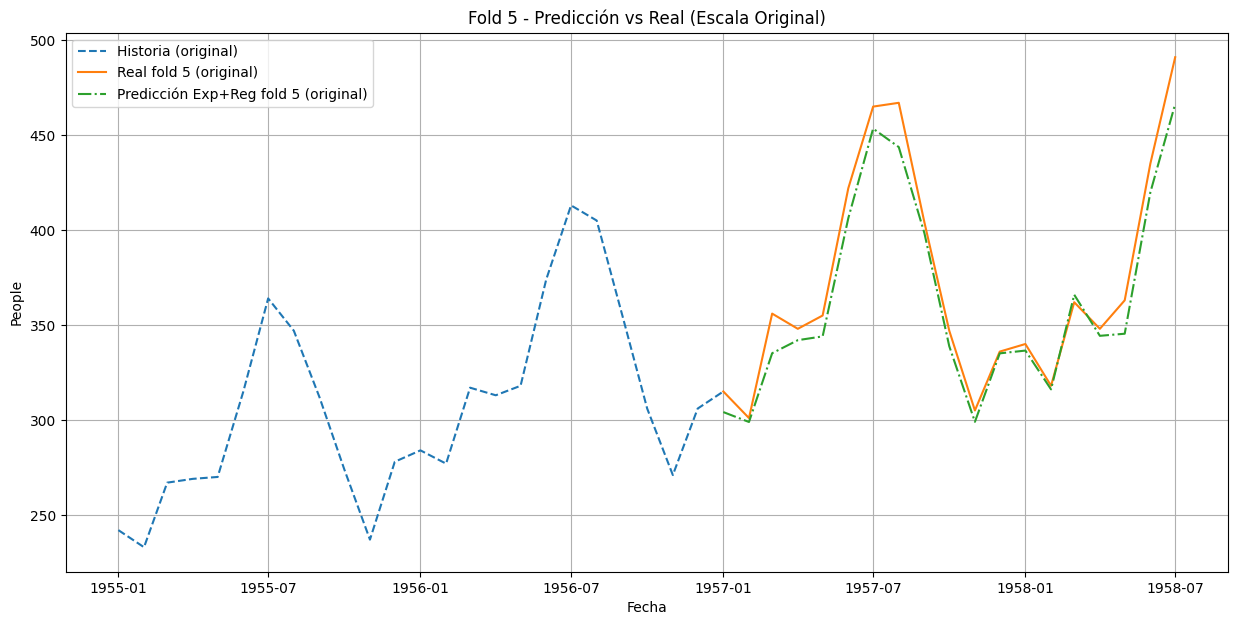

In [85]:
model_name = 'LR+SimpleExpExog'
X = X_train_dum
y = y_train_dum

tcsv = TimeSeriesSplit(n_splits = 5)
fold = 0

#Visualizaciones

train_prev_folds = pd.DataFrame()
model_preds_fold5_list = []
val_fold5_true_vals = []
val_fold5 = None
train_data_transf_fold5 = None
model_mae = []

for train_id, val_id in tscv.split(X):
    fold += 1
    X_train_cv, y_train_cv = X.iloc[train_id], y.iloc[train_id]
    X_val_cv, y_val_cv = X.iloc[val_id], y.iloc[val_id]

    model = LinearRegression().fit(X_train_cv, y_train_cv)

    models_preds_train = model.predict(X_train_cv)
    model_preds_val = model.predict(X_val_cv)

    residual_train = y_train_cv - models_preds_train

    #Modelo Exp

    model_exp_reg = ExponentialSmoothing(residual_train).fit(smoothing_level = 0.35)

    residuals_forecast = model_exp_reg.forecast(len(X_val_cv))

    final_pred = model_preds_val + residuals_forecast

    mae = mean_absolute_error(y_val_cv, final_pred)
    print(f'mae en fold {fold} (transformado): {mae:.4f}')
    model_mae.append(mae)

    #Nivel Gráfico

    if fold < 5:
        temp = y.iloc[val_id].to_frame()
        temp.columns = ['People']
        train_prev_folds = pd.concat([train_prev_folds, temp])
    else:
        val_fold5 = y.iloc[val_id].to_frame()
        val_fold5_true_list = y_val_cv.values
        model_preds_fold5_list = final_pred
        train_data_transf_fold5 = y.iloc[train_id].to_frame()


mean_exp_mae = np.mean(model_mae)

model_scores[model_name] = mean_exp_mae

print(f'\nMAE promedio en escala transformada: {mean_mae_exp:.4f}')
if best_ovr_score > mean_exp_mae:
    best_ovr_score = mean_exp_mae
    print('Nuevo mejor MAE')



pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(exp_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12
)

mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'],
    pred_original_fold5
)
print(f'\nMAE en fold 5 (escala original): {mae_original_fold5:.4f}')



# -------------------------
# GRAFICAR - ESCALA ORIGINAL
# -------------------------
plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)

plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')
plt.plot(df.loc[val_fold5.index, 'People'], label='Real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción Exp+Reg fold 5 (original)', linestyle='-.')

plt.title('Fold 5 - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()


# Modelos AR - MA - ARMA - ARIMA

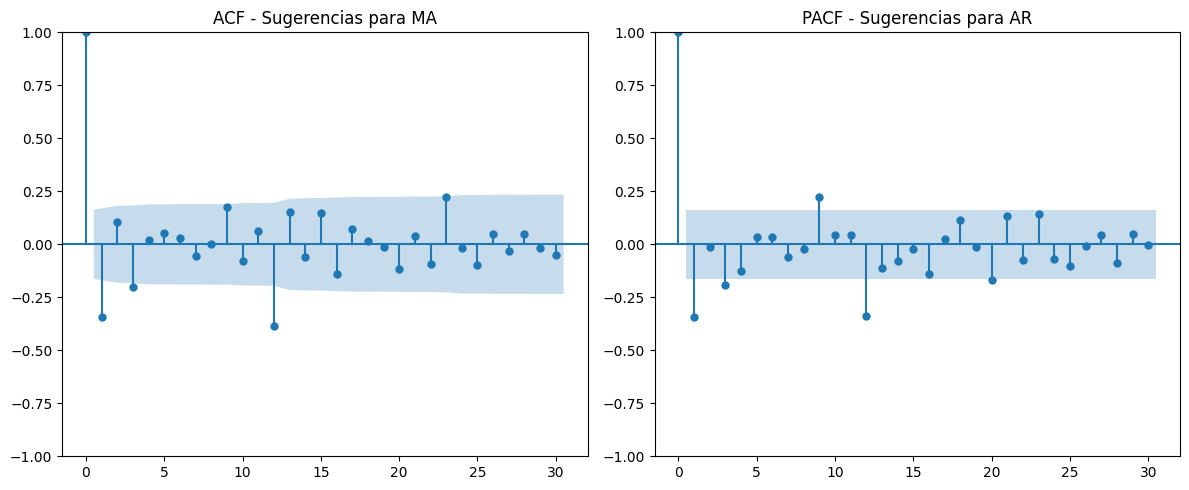

In [68]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df_diffed_season['People'], lags=30, ax=plt.gca())
plt.title('ACF - Sugerencias para MA')

plt.subplot(1, 2, 2)
plot_pacf(df_diffed_season['People'], lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF - Sugerencias para AR')

plt.tight_layout()
plt.show()

Shape of X: (144,), Shape of Y: (144, 2)


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritor


MAE promedio en escala transformada: 0.0345
Nuevo mejor MAE
Longitud de model_arma_preds_fold5_list: 24
Longitud de val_fold5_true_list: 24
Longitud de val_fold5.index: 24

MAE en fold 5 (escala original): 0.0336


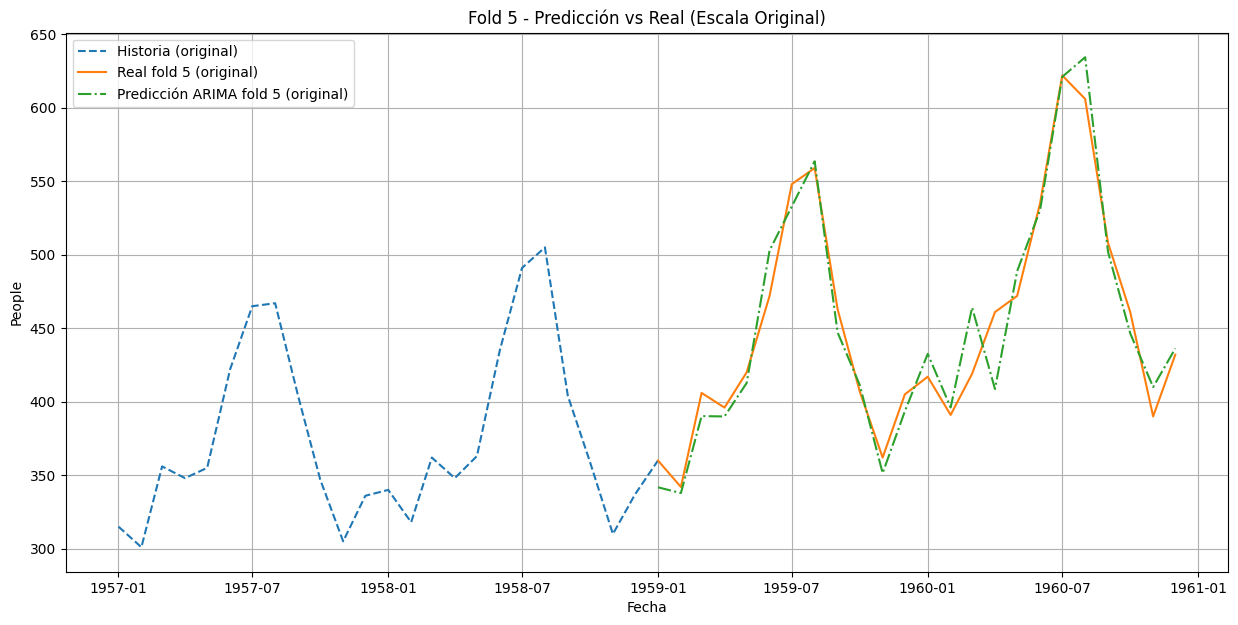

In [86]:
tscv = TimeSeriesSplit(n_splits=5)
mae_arma = []
X = pd.Series(df_diffed_season['People'])
y = df_diffed_season
train_prev_folds = pd.DataFrame()
model_arma_preds_fold5_list = []
val_fold5_true_list = []  # Cambiado a lista directamente
val_fold5 = None
train_data_transf_fold5 = None
fold = 0
model_arma_name = 'ARMA301'


print(f'Shape of X: {X.shape}, Shape of Y: {y.shape}')

for train_id, val_id in tscv.split(X):
    fold += 1
    X_train_cv, y_train_cv = X.iloc[train_id], y.iloc[train_id]
    X_val_cv, y_val_cv = X.iloc[val_id], y.iloc[val_id]
    
    # Ajustar model_armao ARIMA con los datos de entrenamiento
    model_arma = ARIMA(X_train_cv, order=(3,0,1)).fit()
    
    # Predecir el número de pasos correspondiente al tamaño del conjunto de validación
    # Usar forecast en lugar de predict para predicciones fuera de muestra
    model_arma_pred = model_arma.forecast(steps=len(X_val_cv))
    
    # Asegurarse de que las longitudes coincidan para el cálculo del MAE
    # y comparar valores con valores, no con índices
    mae = mean_absolute_error(X_val_cv.values, model_arma_pred)
    mae_arma.append(mae)
    
    if fold < 5:
        # Para los primeros 4 folds
        temp = X.iloc[val_id].copy()
        # Convertir la serie en DataFrame para concatenar
        temp_df = pd.DataFrame(temp)
        train_prev_folds = pd.concat([train_prev_folds, temp_df])
    else:
        # Para el fold 5 (el último)
        val_fold5 = X.iloc[val_id].copy()
        val_fold5_true_list = X_val_cv.tolist()  # Guardar como lista
        # Guardar las predicciones como lista y asegurarnos de que sea del mismo tamaño que val_fold5
        model_arma_preds_fold5_list = model_arma_pred.tolist()
        train_data_transf_fold5 = X.iloc[train_id].copy()
        
mean_arma_mae = np.mean(mae_arma)

model_scores[model_arma_name] = mean_arma_mae

print(f'\nMAE promedio en escala transformada: {mean_arma_mae:.4f}')
if best_ovr_score > mean_arma_mae:
    best_ovr_score = mean_arma_mae
    print('Nuevo mejor MAE')

# IMPORTANTE: Verificar que las longitudes sean iguales antes de invert_transformations_corrected
print(f"Longitud de model_arma_preds_fold5_list: {len(model_arma_preds_fold5_list)}")
print(f"Longitud de val_fold5_true_list: {len(val_fold5_true_list)}")
print(f"Longitud de val_fold5.index: {len(val_fold5.index)}")

# Si hay discrepancia entre las longitudes, necesitamos ajustar
if len(val_fold5.index) != len(model_arma_preds_fold5_list):
    # Opción 1: Truncar las predicciones para que coincidan con el índice
    model_arma_preds_fold5_list = model_arma_preds_fold5_list[:len(val_fold5.index)]
    val_fold5_true_list = val_fold5_true_list[:len(val_fold5.index)]
    
    # Opción 2 (alternativa): Truncar el índice para que coincida con las predicciones
    # val_fold5 = val_fold5.iloc[:len(model_arma_preds_fold5_list)]

pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(model_arma_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12
)

mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'],
    pred_original_fold5
)
print(f'\nMAE en fold 5 (escala original): {mae_original_fold5:.4f}')

# -------------------------
# GRAFICAR - ESCALA ORIGINAL
# -------------------------
plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')
plt.plot(df.loc[val_fold5.index, 'People'], label='Real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción ARIMA fold 5 (original)', linestyle='-.')
plt.title('Fold 5 - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()

# Sarimax con variables Exogenas

Es decir variables dummy que explican el comportamiento de la variable Y 

c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javi

El MAE obtenido en el split: 1 fue de: 0.0545


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El MAE obtenido en el split: 2 fue de: 0.0529


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El MAE obtenido en el split: 3 fue de: 0.0411
El MAE obtenido en el split: 4 fue de: 0.0232


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El MAE obtenido en el split: 5 fue de: 0.0139

MAE promedio en escala transformada: 0.0371

MAE en fold 5 (escala original): 0.0140


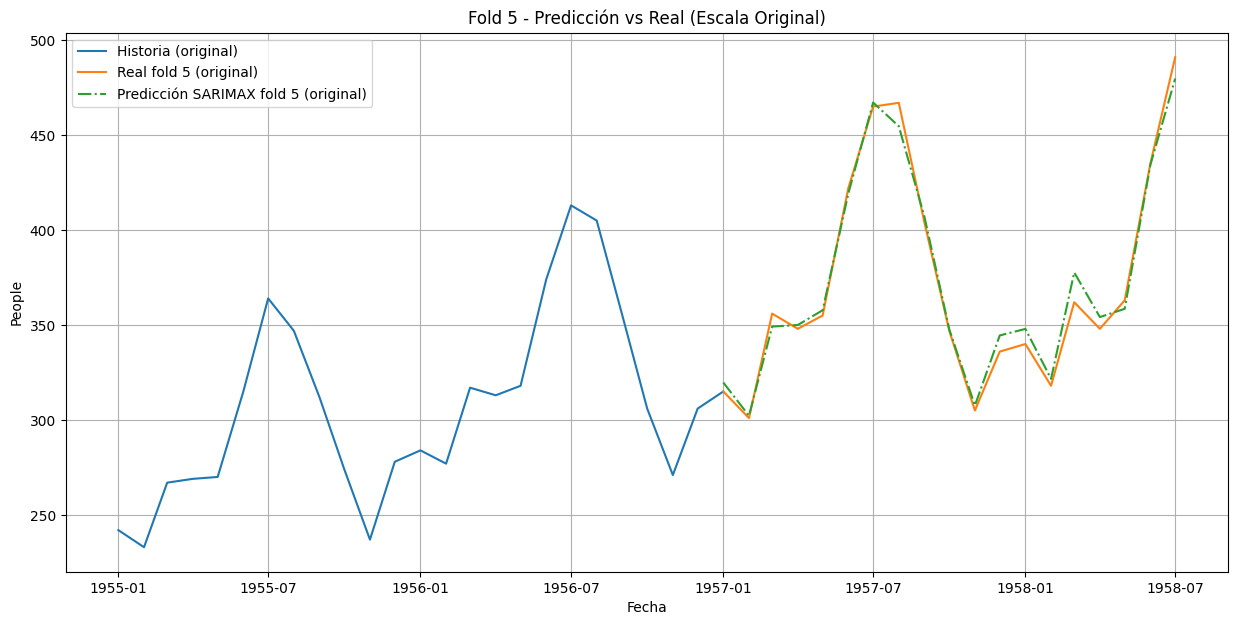

In [87]:
model_name = 'ARIMA301Exog'
tscv = TimeSeriesSplit(n_splits=5)
mae_arma = []
y = df_train_dum['People']
X = df_train_dum.drop(['People'], axis=1)

train_prev_folds = pd.DataFrame()
model_preds_fold5_list = []
val_fold5_true_list = []
val_fold5 = None
train_data_transf_fold5 = None
fold = 0

for train_id, val_id in tscv.split(X):
    fold += 1
    X_train_cv, y_train_cv = X.iloc[train_id], y.iloc[train_id]
    X_val_cv, y_val_cv = X.iloc[val_id], y.iloc[val_id]

    y_train_cv = y_train_cv.astype(float)
    X_train_cv = X_train_cv.astype(float)
    X_val_cv = X_val_cv.astype(float)

    # SARIMAX con variables exógenas
    model_arma_exog = SARIMAX(y_train_cv, exog=X_train_cv, order=(3,0,1), seasonal_order=(0,0,0,0))
    res_model_arma_exog = model_arma_exog.fit(disp=False)

    # Predicción sobre el conjunto de validación
    model_pred = res_model_arma_exog.forecast(steps=len(X_val_cv), exog=X_val_cv)

    # Cálculo del MAE
    mae = mean_absolute_error(y_val_cv, model_pred)
    mae_arma.append(mae)
    print(f'El MAE obtenido en el split: {fold} fue de: {mae:.4f}')

    if fold < 5:
        temp_df = pd.DataFrame(X.iloc[val_id])
        train_prev_folds = pd.concat([train_prev_folds, temp_df])
    else:
        val_fold5 = X.iloc[val_id].copy()
        val_fold5_true_list = y_val_cv.tolist()
        model_preds_fold5_list = model_pred.tolist()
        train_data_transf_fold5 = X.iloc[train_id].copy()

# Evaluación final
mean_arma_mae = np.mean(mae_arma)
model_scores[model_name] = mean_arma_mae
print(f'\nMAE promedio en escala transformada: {mean_arma_mae:.4f}')
if best_ovr_score > mean_arma_mae:
    best_ovr_score = mean_arma_mae
    print('Nuevo mejor MAE')

# Asegurar coincidencia de longitudes antes de invertir transformaciones
if len(val_fold5.index) != len(model_preds_fold5_list):
    model_preds_fold5_list = model_preds_fold5_list[:len(val_fold5.index)]
    val_fold5_true_list = val_fold5_true_list[:len(val_fold5.index)]

# Inversión de transformaciones
pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(model_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12
)

# MAE en escala original
mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'],
    pred_original_fold5
)
print(f'\nMAE en fold 5 (escala original): {mae_original_fold5:.4f}')

# Gráfico
plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)')
plt.plot(df.loc[val_fold5.index, 'People'], label='Real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción SARIMAX fold 5 (original)', linestyle='-.')
plt.title('Fold 5 - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()

# más modelos aplicables 

VAR -> Vector AutoRegression: Dependen de que todas las variables sean estacionarias, Bueno para modelos multivariantes.


ARCH Y GARCH: 

La serie parece presentar heterocedasticidad, grandes cambios en la amplitud, lo mismo para la media, pero en menor escala, un modelo GARCH sería mejor.

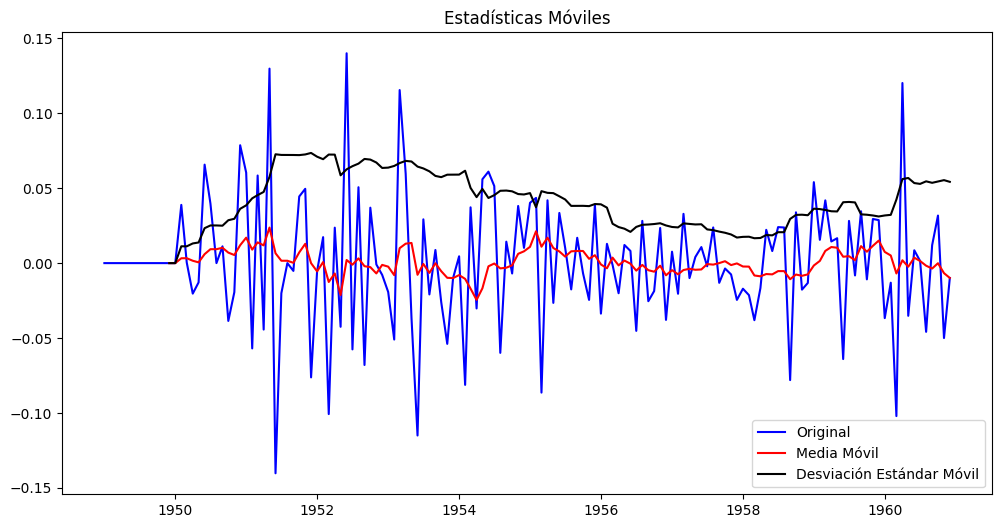


Resultados del Test de Dickey-Fuller para:
Test_stat           -3.993911
p-val                0.001443
Lags_used           11.000000
N _observations    132.000000
1%                  -3.480888
5%                  -2.883697
10%                 -2.578586
dtype: float64
Resultado: La serie es ESTACIONARIA (se rechaza la hipótesis nula)


In [71]:
dickey_fuller(df_diffed_season.People, window = 12)

Shape of X: (144,)
Fold 1 - MAE: 0.0524
Fold 2 - MAE: 0.0416
Fold 3 - MAE: 0.0273
Fold 4 - MAE: 0.0202
Fold 5 - MAE: 0.0339

MAE promedio en escala transformada: 0.0351
Nuevo mejor MAE

MAE en fold 5 (escala original): 0.0339


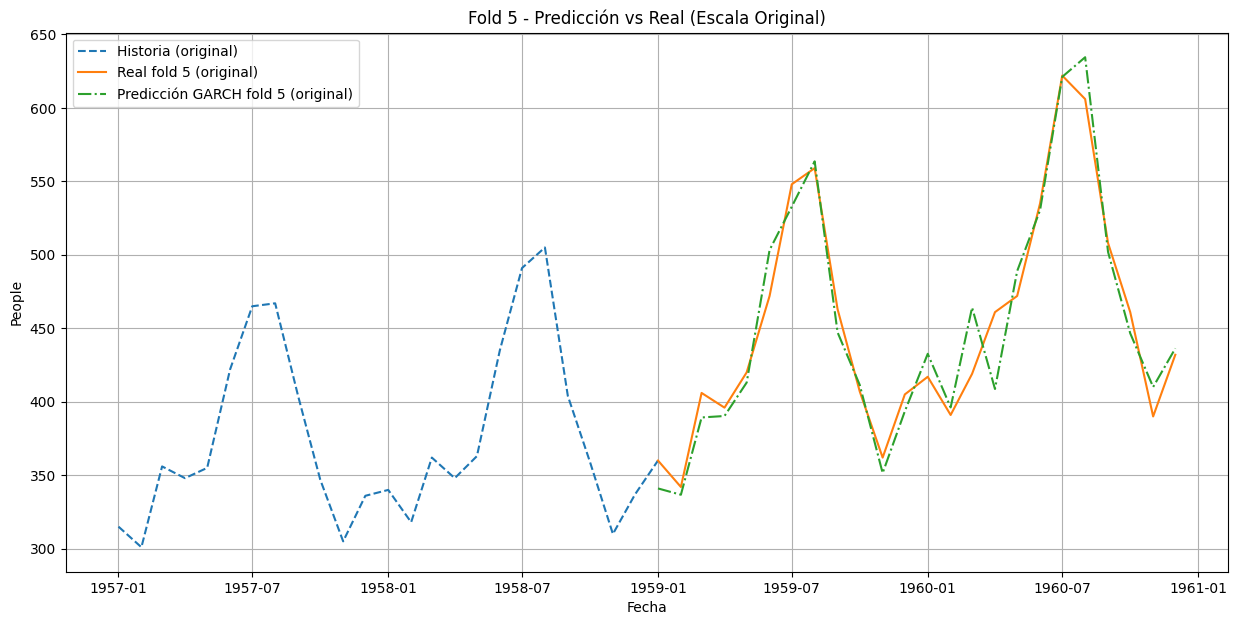

In [94]:
model_name = 'GARCH'
tscv = TimeSeriesSplit(n_splits=5)
mae_arma = []


X = pd.Series(df_diffed_season['People'])
y = df_diffed_season  

train_prev_folds = pd.DataFrame()
model_preds_fold5_list = []
val_fold5_true_list = []
val_fold5 = None
train_data_transf_fold5 = None
fold = 0

print(f'Shape of X: {X.shape}')

for train_id, val_id in tscv.split(X):
    fold += 1
    X_train_cv, y_train_cv = X.iloc[train_id], X.iloc[train_id]
    X_val_cv, y_val_cv = X.iloc[val_id], X.iloc[val_id]

    model_garch = arch_model(y_train_cv, vol='GARCH', p=2, q=1, mean='AR', rescale = False)
    results = model_garch.fit(disp=False)

    forecast = results.forecast(horizon=len(X_val_cv))
    model_pred = forecast.mean.iloc[-1].values  

    mae = mean_absolute_error(X_val_cv.values, model_pred)
    mae_arma.append(mae)
    print(f'Fold {fold} - MAE: {mae:.4f}')

    if fold < 5:
        temp = pd.DataFrame(X.iloc[val_id])
        train_prev_folds = pd.concat([train_prev_folds, temp])
    else:
        val_fold5 = X.iloc[val_id].copy()
        val_fold5_true_list = X_val_cv.tolist()
        model_preds_fold5_list = model_pred.tolist()
        train_data_transf_fold5 = X.iloc[train_id].copy()

# MAE promedio
mean_garch_mae = np.mean(mae_arma)
model_scores[model_name] = mean_garch_mae
print(f'\nMAE promedio en escala transformada: {mean_garch_mae:.4f}')

if best_ovr_score > mean_garch_mae:
    best_ovr_score = mean_garch_mae
    print('Nuevo mejor MAE')

# Asegurar coincidencia de longitudes
if len(val_fold5.index) != len(model_preds_fold5_list):
    model_preds_fold5_list = model_preds_fold5_list[:len(val_fold5.index)]
    val_fold5_true_list = val_fold5_true_list[:len(val_fold5.index)]

# Inversión de transformaciones
pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(model_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12
)

# MAE en escala original
mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'],
    pred_original_fold5
)
print(f'\nMAE en fold 5 (escala original): {mae_original_fold5:.4f}')

# -------------------------
# GRAFICAR - ESCALA ORIGINAL
# -------------------------
plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')
plt.plot(df.loc[val_fold5.index, 'People'], label='Real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción GARCH fold 5 (original)', linestyle='-.')
plt.title('Fold 5 - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()


Shape of X: (144,)
Fold 1 - MAE: 0.0524
Fold 2 - MAE: 0.0416
Fold 3 - MAE: 0.0273
Fold 4 - MAE: 0.0202
Fold 5 - MAE: 0.0339

MAE promedio en escala transformada: 0.0351

MAE en fold 5 (escala original): 0.0339


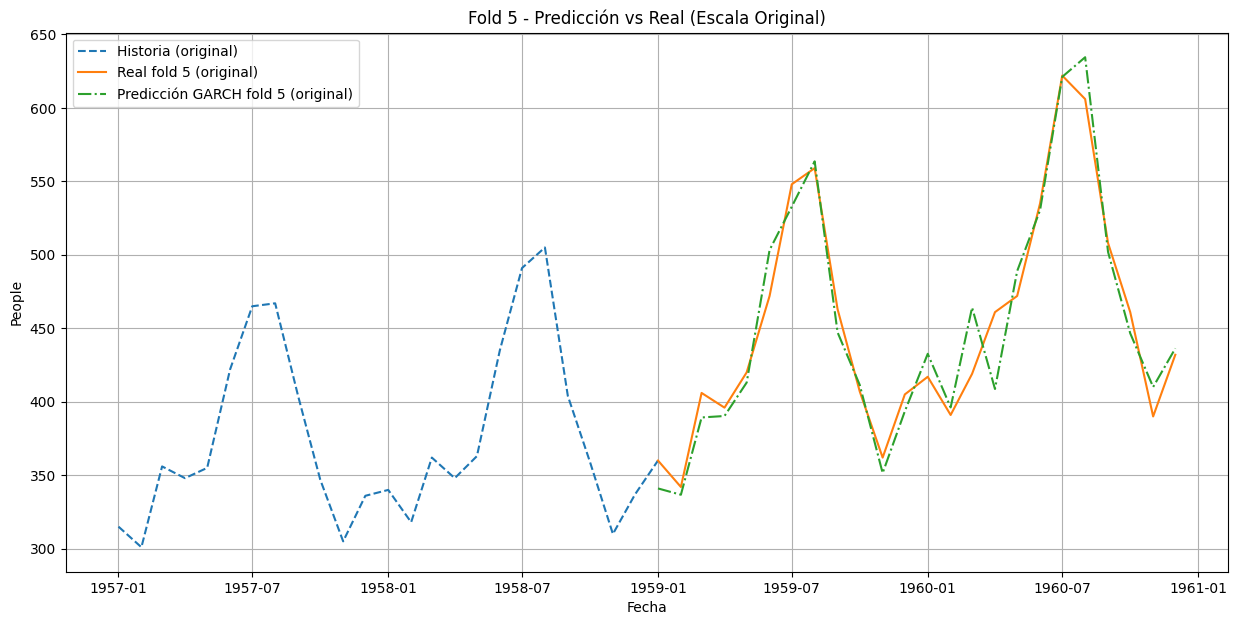

In [73]:
tscv = TimeSeriesSplit(n_splits=5)
mae_arma = []
model_name = 'ARCH'

# X será la serie con la variable objetivo
X = pd.Series(df_diffed_season['People'])

train_prev_folds = pd.DataFrame()
model_preds_fold5_list = []
val_fold5_true_list = []
val_fold5 = None
train_data_transf_fold5 = None
fold = 0

print(f'Shape of X: {X.shape}')

for train_id, val_id in tscv.split(X):
    fold += 1
    X_train_cv, y_train_cv = X.iloc[train_id], X.iloc[train_id]
    X_val_cv, y_val_cv = X.iloc[val_id], X.iloc[val_id]

    model_arch = arch_model(y_train_cv, p=2, q=1, mean='AR', rescale=False)
    results = model_arch.fit(disp=False)

    forecast = results.forecast(horizon=len(X_val_cv))
    model_pred = forecast.mean.iloc[-1].values  # Solo la predicción de la media

    mae = mean_absolute_error(X_val_cv.values, model_pred)
    mae_arma.append(mae)
    print(f'Fold {fold} - MAE: {mae:.4f}')

    if fold < 5:
        temp = pd.DataFrame(X.iloc[val_id])
        train_prev_folds = pd.concat([train_prev_folds, temp])
    else:
        val_fold5 = X.iloc[val_id].copy()
        val_fold5_true_list = X_val_cv.tolist()
        model_preds_fold5_list = model_pred.tolist()
        train_data_transf_fold5 = X.iloc[train_id].copy()

# MAE promedio
mean_arch_mae = np.mean(mae_arma)
model_scores[model_name] = mean_garch_mae
print(f'\nMAE promedio en escala transformada: {mean_arch_mae:.4f}')

if best_ovr_score > mean_arch_mae:
    best_ovr_score = mean_arch_mae
    print('Nuevo mejor MAE')

# Asegurar coincidencia de longitudes
if len(val_fold5.index) != len(model_preds_fold5_list):
    model_preds_fold5_list = model_preds_fold5_list[:len(val_fold5.index)]
    val_fold5_true_list = val_fold5_true_list[:len(val_fold5.index)]

# Inversión de transformaciones
pred_original_fold5, true_original_reconstructed_fold5 = invert_transformations_corrected(
    y_transformed_pred_array=np.array(model_preds_fold5_list),
    y_transformed_true_array=np.array(val_fold5_true_list),
    prediction_datetime_index=val_fold5.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12
)

# MAE en escala original
mae_original_fold5 = mean_absolute_percentage_error(
    df.loc[val_fold5.index, 'People'],
    pred_original_fold5
)
print(f'\nMAE en fold 5 (escala original): {mae_original_fold5:.4f}')

# -------------------------
# GRAFICAR - ESCALA ORIGINAL
# -------------------------
plt.figure(figsize=(15, 7))
history_idx_end = val_fold5.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')
plt.plot(df.loc[val_fold5.index, 'People'], label='Real fold 5 (original)')
plt.plot(val_fold5.index, pred_original_fold5, label='Predicción GARCH fold 5 (original)', linestyle='-.')
plt.title('Fold 5 - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()


# LSTM




--- Fold 1 ---
Fold 1: Entrenando LSTM...


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MAE en fold 1 (escalado): 0.4454

--- Fold 2 ---
Fold 2: Entrenando LSTM...


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
MAE en fold 2 (escalado): 0.1577

--- Fold 3 ---
Fold 3: Entrenando LSTM...


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MAE en fold 3 (escalado): 0.1003

--- Fold 4 ---
Fold 4: Entrenando LSTM...


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
MAE en fold 4 (escalado): 0.0678

--- Fold 5 ---
Fold 5: Entrenando LSTM...


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MAE en fold 5 (escalado): 0.1224

MAE promedio en escala transformada y escalada (LSTM): 0.1787
Nuevo mejor MAE (LSTM en datos escalados)

Invirtiendo transformaciones para Fold 5...

MAPE en fold 5 (escala original con LSTM): 0.0344
MAE en fold 5 (escala original con LSTM): 15.4093


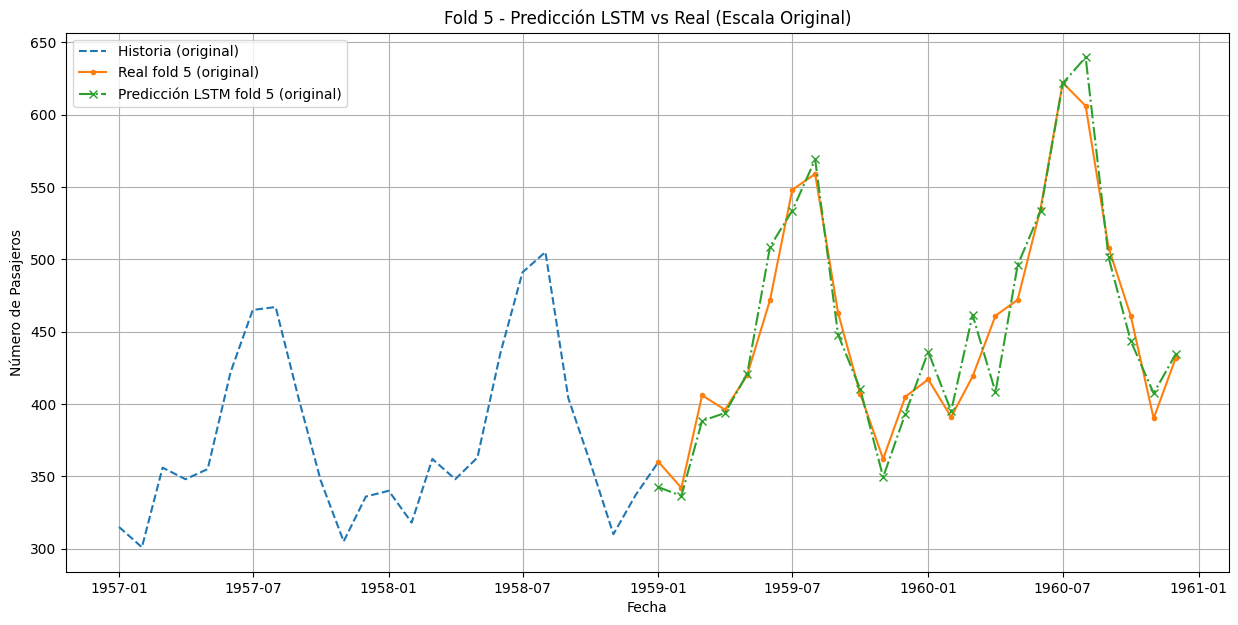

In [93]:

target_series = df_diffed_season['People'] 
model_name = 'LSTM'

exog_features = pd.get_dummies(target_series.index.month, prefix='month', drop_first=True)
exog_features.index = target_series.index

common_index = target_series.index.intersection(exog_features.index)
y_processed = target_series.loc[common_index]
X_processed = exog_features.loc[common_index]

# --- Parámetros del LSTM ---
LOOK_BACK = 12 # Número de timesteps pasados a considerar
N_FEATURES_EXOG = X_processed.shape[1] # Número de características exógenas
N_FEATURES_LSTM = 1 + N_FEATURES_EXOG # 1 para la serie objetivo + exógenas

# --- 1. Función para crear secuencias para LSTM ---
def create_sequences_with_exog(target_data, exog_data, look_back):
    """
    Prepara datos para LSTM con características exógenas.
    target_data: array 2D (N, 1) de la serie objetivo escalada.
    exog_data: array 2D (N, N_FEATURES_EXOG) de las características exógenas escaladas (o ya en rango adecuado).
    look_back: número de timesteps pasados.
    """
    X_seq, y_seq = [], []
    if len(target_data) != len(exog_data):
        raise ValueError("target_data y exog_data deben tener la misma longitud.")
    if len(target_data) <= look_back:
        return np.array(X_seq), np.array(y_seq) # No hay suficientes datos

    for i in range(len(target_data) - look_back):
        # Secuencia de la variable objetivo
        target_hist_seq = target_data[i:(i + look_back), 0]
        # Secuencia correspondiente de características exógenas
        # Usamos las exógenas de los mismos timesteps que los lags de la target
        exog_hist_seq = exog_data[i:(i + look_back), :]

        # Combinar: [lag_target, exog1, exog2, ...] para cada timestep en look_back
        combined_features_for_timesteps = np.hstack(
            (target_hist_seq.reshape(look_back, 1), exog_hist_seq)
        )
        X_seq.append(combined_features_for_timesteps)
        y_seq.append(target_data[i + look_back, 0]) # El siguiente valor de la target

    return np.array(X_seq), np.array(y_seq)

X = X_processed # DataFrame (N, N_FEATURES_EXOG)
y = y_processed # Series (N,)

tcsv = TimeSeriesSplit(n_splits=5)
fold = 0

train_prev_folds_transformed = pd.DataFrame() # Almacenará y_val_cv (transformada, no escalada)
model_preds_fold5_list_scaled = [] # Almacenará predicciones escaladas para el fold 5
val_fold5_true_vals_scaled = []    # Almacenará valores reales escalados para el fold 5
val_fold5_transformed = None       # Almacenará y_val_cv (transformada, no escalada) para el fold 5
train_data_transf_fold5 = None # Almacenará y_train_cv (transformada, no escalada) para el fold 5
model_mae_lstm = [] # MAE en datos escalados

best_ovr_score = np.inf # Para seguir el mejor MAE

for train_id, val_id in tcsv.split(X): # X y 'y' deben tener el mismo número de filas
    fold += 1
    print(f"\n--- Fold {fold} ---")

    # Separar datos del fold para 'y' (target) y 'X' (exógenas)
    y_train_cv, y_val_cv = y.iloc[train_id], y.iloc[val_id]         # Series (transformadas, no escaladas)
    X_train_cv, X_val_cv = X.iloc[train_id], X.iloc[val_id]         # DataFrame (exógenas, no escaladas)

    # --- Escalado ---
    # Escalar la variable objetivo 'y'
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.values.reshape(-1, 1))
    y_val_cv_scaled = scaler_y.transform(y_val_cv.values.reshape(-1, 1))

    # Escalar las características exógenas 'X' (si no son dummies ya en 0/1)
    # Las dummies de mes ya están en [0,1], así que no es estrictamente necesario escalarlas,
    # pero si hubiera otras exógenas, se escalarían aquí.
    # Para ser consistentes, podríamos escalarlas, aunque no cambiará mucho para dummies.
    scaler_X = MinMaxScaler(feature_range=(0, 1)) # Usar un scaler diferente o el mismo si se concatenan antes
    X_train_cv_scaled = scaler_X.fit_transform(X_train_cv.values)
    X_val_cv_scaled = scaler_X.transform(X_val_cv.values)

    # --- Preparar secuencias para LSTM ---
    # Secuencias de entrenamiento
    X_lstm_train, y_lstm_train = create_sequences_with_exog(
        y_train_cv_scaled, X_train_cv_scaled, LOOK_BACK
    )

    # Secuencias de validación
    # Necesitamos los últimos `LOOK_BACK` puntos del historial de entrenamiento para formar las primeras secuencias de validación
    if len(y_train_cv_scaled) < LOOK_BACK:
        print(f"Fold {fold}: No suficientes datos de entrenamiento ({len(y_train_cv_scaled)}) para look_back ({LOOK_BACK}). Saltando fold.")
        # Opcionalmente, reducir look_back para este fold si es posible, o manejarlo.
        # Por ahora, lo saltamos si no hay suficientes datos.
        # Si X_lstm_train está vacío, el modelo no se puede entrenar.
        if X_lstm_train.shape[0] == 0:
            model_mae_lstm.append(np.nan) # o algún valor alto
            continue


    # Combinar la cola del train con el val para crear las secuencias de validación
    y_for_val_seq_creation = np.vstack((y_train_cv_scaled[-LOOK_BACK:], y_val_cv_scaled))
    X_for_val_seq_creation = np.vstack((X_train_cv_scaled[-LOOK_BACK:], X_val_cv_scaled))

    X_lstm_val, y_lstm_val_true_targets = create_sequences_with_exog(
        y_for_val_seq_creation, X_for_val_seq_creation, LOOK_BACK
    )
    # y_lstm_val_true_targets son los valores reales (escalados) que queremos predecir para el conjunto de validación.
    # Deberían corresponder a y_val_cv_scaled (o una porción de él si create_sequences hace algún recorte).
    # Con la implementación actual, y_lstm_val_true_targets son los últimos len(y_val_cv_scaled) elementos.

    if X_lstm_train.shape[0] == 0 or X_lstm_val.shape[0] == 0:
        print(f"Fold {fold}: No se pudieron crear secuencias de entrenamiento o validación. Saltando.")
        model_mae_lstm.append(np.nan)
        continue

    # --- Definir y Entrenar el Modelo LSTM ---
    model = Sequential()
    model.add(LSTM(30, activation='relu', input_shape=(LOOK_BACK, N_FEATURES_LSTM)))
    # model.add(LSTM(50, activation='relu', input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))) # Alternativa
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print(f"Fold {fold}: Entrenando LSTM...")
    history = model.fit(
        X_lstm_train, y_lstm_train,
        epochs=100, # Aumentar para problemas reales
        batch_size=16, # Ajustar según el tamaño del dataset
        validation_data=(X_lstm_val, y_lstm_val_true_targets),
        callbacks=[early_stopping],
        verbose=0 # 0 para silenciar, 1 para barra de progreso, 2 para una línea por epoch
    )

    # --- Predicción y Evaluación del Fold ---
    # Predecir sobre el conjunto de validación (escalado)
    preds_val_scaled = model.predict(X_lstm_val).flatten()

    # Calcular MAE sobre datos escalados (para comparar con EGARCH si se hizo igual)
    mae_scaled = mean_absolute_error(y_lstm_val_true_targets, preds_val_scaled)
    print(f'MAE en fold {fold} (escalado): {mae_scaled:.4f}')
    model_mae_lstm.append(mae_scaled)

    # --- Almacenar datos para gráficos y análisis del fold 5 ---
    if fold < 5:
        # train_prev_folds_transformed almacena los y_val_cv (transformados, no escalados) de folds anteriores
        temp_df = y_val_cv.to_frame()
        temp_df.columns = ['People_transformed'] # Renombrar para claridad
        train_prev_folds_transformed = pd.concat([train_prev_folds_transformed, temp_df])
    else: # fold == 5
        val_fold5_transformed = y_val_cv.to_frame()
        val_fold5_transformed.columns = ['People_transformed']

        # Almacenamos las predicciones y reales DEL ÚLTIMO FOLD (fold 5)
        # Estas son las versiones ESCALADAS, que luego des-escalaremos
        model_preds_fold5_list_scaled = preds_val_scaled
        val_fold5_true_vals_scaled = y_lstm_val_true_targets.flatten() # Asegurar que sea 1D

        # También guardamos los datos de entrenamiento del fold 5 (transformados, no escalados)
        train_data_transf_fold5 = y_train_cv.to_frame()
        train_data_transf_fold5.columns = ['People_transformed']

# --- Resultados Finales del Cross-Validation ---
model_mae_lstm = [m for m in model_mae_lstm if not np.isnan(m)] # Remover NaNs si algún fold se saltó
if model_mae_lstm:
    mean_lstm_mae_scaled = np.mean(model_mae_lstm)
    model_scores[model_name] = mean_lstm_mae_scaled
    print(f'\nMAE promedio en escala transformada y escalada (LSTM): {mean_lstm_mae_scaled:.4f}')
    if best_ovr_score > mean_lstm_mae_scaled:
        best_ovr_score = mean_lstm_mae_scaled
        print('Nuevo mejor MAE (LSTM en datos escalados)')
else:
    print("\nNo se completó ningún fold del LSTM.")


# --- Inversión de transformaciones para el Fold 5 y Evaluación en Escala Original ---
if fold == 5 and val_fold5_transformed is not None and len(model_preds_fold5_list_scaled) > 0:
    # 1. Des-escalar las predicciones y los valores reales del fold 5
    pred_fold5_transformed_unscaled = scaler_y.inverse_transform(model_preds_fold5_list_scaled.reshape(-1, 1)).flatten()
    true_fold5_transformed_unscaled = scaler_y.inverse_transform(val_fold5_true_vals_scaled.reshape(-1, 1)).flatten()

    # El índice para estas predicciones/reales des-escaladas es el índice de y_val_cv del fold 5
    prediction_datetime_index_fold5 = y_val_cv.index # Este es el DatetimeIndex que queremos usar

    # 2. Invertir las transformaciones (diff, log) para obtener la escala original
    print("\nInvirtiendo transformaciones para Fold 5...")

    # Asumimos que invert_transformations_corrected devuelve arrays de NumPy o Series con un índice genérico.
    # Los nombres de las variables devueltas se cambian temporalmente para mayor claridad.
    temp_pred_values, temp_true_reconstructed_values = invert_transformations_corrected(
        y_transformed_pred_array=pred_fold5_transformed_unscaled,
        y_transformed_true_array=true_fold5_transformed_unscaled,
        prediction_datetime_index=prediction_datetime_index_fold5, # Pasamos el índice por si la función lo usa internamente
        original_full_log_series=df_log['People'],
        original_full_log_diff1_series=df_diffed['People'],
        seasonal_lag=12 # Asegúrate de que esta variable esté definida
    )

    # --- ASEGURAR EL ÍNDICE CORRECTO PARA LAS PREDICCIONES ---
    # Primero, verifica que las longitudes coincidan (esto debería estar resuelto si el ValueError anterior se corrigió)
    if len(temp_pred_values) == len(prediction_datetime_index_fold5):
        pred_original_fold5 = pd.Series(temp_pred_values, index=prediction_datetime_index_fold5, name='People_Predicted_LSTM')
    else:
        print(f"¡ERROR DE LONGITUD PERSISTENTE! Longitud de predicciones invertidas: {len(temp_pred_values)}, "
              f"Longitud del índice esperado: {len(prediction_datetime_index_fold5)}")
        # Si esto sucede, el gráfico y el MAPE seguirán siendo incorrectos.
        # Debes resolver por qué `invert_transformations_corrected` cambia la longitud.
        # Como fallback para evitar un error en el ploteo, pero esto oculta el problema:
        pred_original_fold5 = pd.Series(dtype=float) # Serie vacía para evitar errores de ploteo

    # Opcional: Hacer lo mismo para true_original_reconstructed_fold5 si lo usas para algo más o lo graficas
    if len(temp_true_reconstructed_values) == len(prediction_datetime_index_fold5):
        true_original_reconstructed_fold5 = pd.Series(temp_true_reconstructed_values, index=prediction_datetime_index_fold5, name='People_True_Reconstructed')
    else:
        # Manejar error de longitud si es necesario
        true_original_reconstructed_fold5 = pd.Series(dtype=float)


    # Valores reales en escala original directamente del DataFrame original
    true_values_original_scale_fold5 = df.loc[prediction_datetime_index_fold5, 'People'] # Ya es una Serie con DatetimeIndex

    # Calcular MAPE o MAE en escala original
    # Asegúrate de que ambas sean Series con el mismo índice o arrays NumPy de la misma longitud.
    # Sklearn metrics maneja bien arrays NumPy.
    if not pred_original_fold5.empty and len(true_values_original_scale_fold5) == len(pred_original_fold5):
        mape_original_fold5_lstm = mean_absolute_percentage_error(
            true_values_original_scale_fold5.values, # .values para consistencia si se mezclan Series y arrays
            pred_original_fold5.values
        )
        mae_original_fold5_lstm = mean_absolute_error(
            true_values_original_scale_fold5.values,
            pred_original_fold5.values
        )
        print(f'\nMAPE en fold 5 (escala original con LSTM): {mape_original_fold5_lstm:.4f}')
        print(f'MAE en fold 5 (escala original con LSTM): {mae_original_fold5_lstm:.4f}')
    else:
        print("Cálculo de MAPE/MAE omitido debido a problemas de longitud o predicciones vacías.")
        mape_original_fold5_lstm = np.nan
        mae_original_fold5_lstm = np.nan

    # --- Gráfico en Escala Original para Fold 5 ---
    plt.figure(figsize=(15, 7))

    # Historia: últimos 24 meses antes del fold 5 de validación
    history_end_date = prediction_datetime_index_fold5[0]
    history_start_date = history_end_date - pd.DateOffset(months=24)
    # Es buena práctica verificar si history_start_date es válido o usar try-except
    try:
        plt.plot(df.loc[history_start_date:history_end_date, 'People'], label='Historia (original)', linestyle='--')
    except KeyError:
        print(f"Advertencia: No se pudo encontrar el rango de fechas completo para la historia: {history_start_date} a {history_end_date}")
        # Podrías graficar solo lo que esté disponible, o la historia de y_train_cv si es más fácil
        if train_data_transf_fold5 is not None: # Asumiendo que train_data_transf_fold5 es la y_train_cv del fold 5
             # Necesitarías invertir la transformación de train_data_transf_fold5 también para plotear en escala original
             pass


    # Datos reales del fold 5
    plt.plot(true_values_original_scale_fold5, label='Real fold 5 (original)', marker='.')

    # Predicciones del fold 5
    if not pred_original_fold5.empty: # Solo graficar si tenemos predicciones válidas
        plt.plot(pred_original_fold5, label='Predicción LSTM fold 5 (original)', linestyle='-.', marker='x')
    else:
        print("No se grafican las predicciones LSTM debido a errores previos.")

    plt.title('Fold 5 - Predicción LSTM vs Real (Escala Original)')
    plt.xlabel('Fecha')
    plt.ylabel('Número de Pasajeros')
    plt.legend()
    plt.grid(True)
    plt.show()

#ARCH EXOG

# Evaluación de los modelos

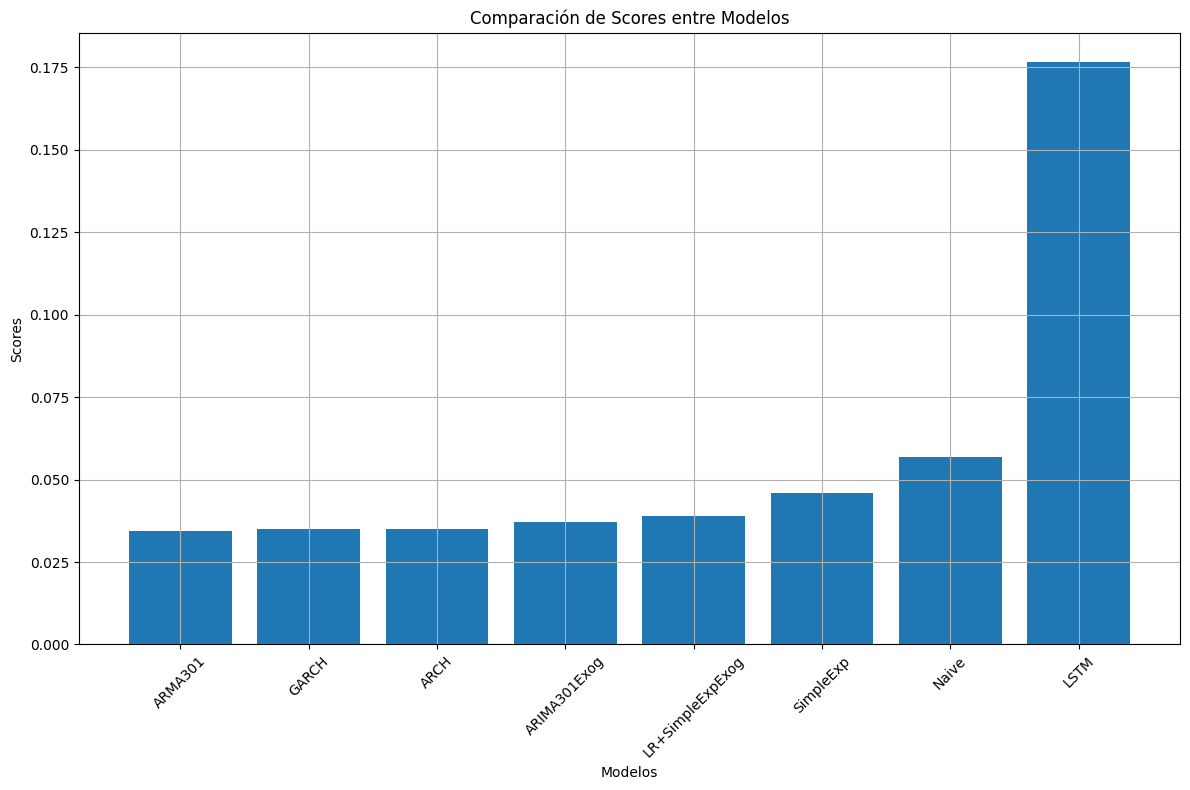

{'ARMA301': np.float64(0.034459347772913415),
 'GARCH': np.float64(0.03506653537485888),
 'ARCH': np.float64(0.03506653537485888),
 'ARIMA301Exog': np.float64(0.037119536277599174),
 'LR+SimpleExpExog': np.float64(0.038936120703815635),
 'SimpleExp': np.float64(0.04603557056758543),
 'Naive': np.float64(0.0568875049693978),
 'LSTM': np.float64(0.17663758685786088)}

In [75]:
model_scores_sorted = dict(sorted(model_scores.items(), key=lambda item: item[1]))
model_names = model_scores_sorted.keys()
model_scores_val = model_scores_sorted.values()
plt.figure(figsize=(12,8))
plt.bar(model_names,model_scores_val )
plt.xlabel('Modelos')
plt.ylabel('Scores')
plt.title('Comparación de Scores entre Modelos')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()
model_scores_sorted

# Predicciones en test

ARMA MODEL PREDICTIONS

mape en fold 5 (escala original): 1.0000


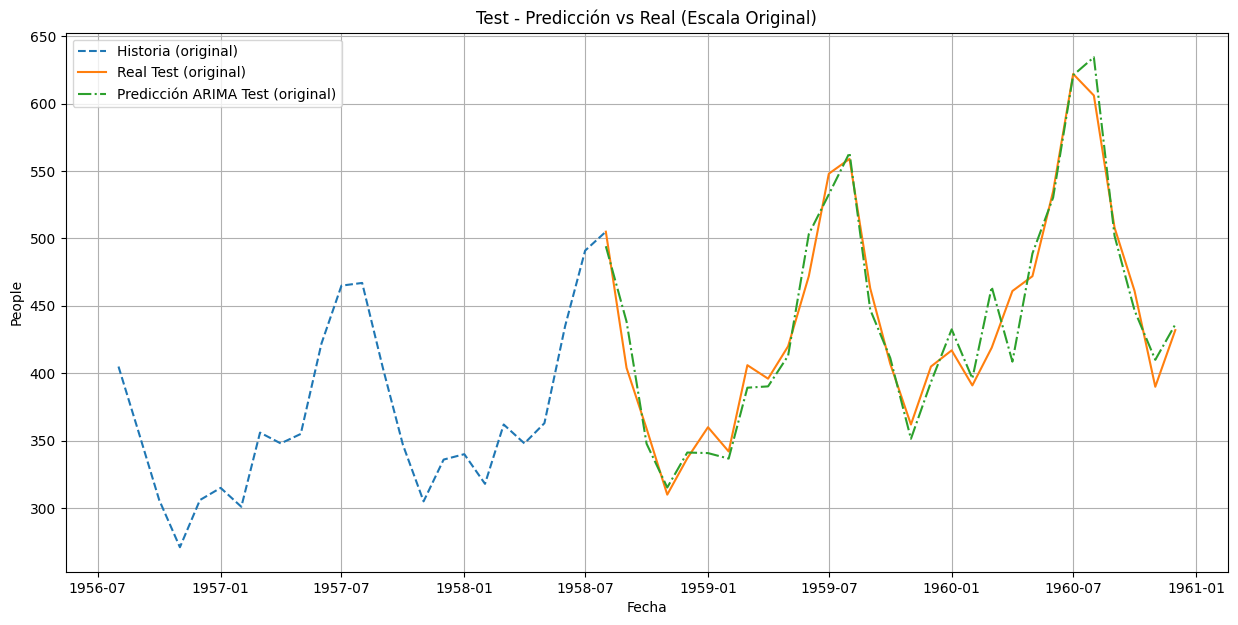

In [92]:
print(f'ARMA MODEL PREDICTIONS')
model_arma_preds = []
model_arma_preds = model_arma.forecast(steps = len(X_test))

pred_array_for_inversion = np.array(model_arma_preds.values)
true_array_for_inversion = np.array(X_test)

pred_original_test, true_original_reconstructed_test = invert_transformations_corrected(
    y_transformed_pred_array=pred_array_for_inversion, 
    y_transformed_true_array=true_array_for_inversion, 
    prediction_datetime_index=X_test.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12 
)


mape_original_test = mean_absolute_percentage_error(
    df.loc[X_test.index, 'People'],
    model_arma_preds
)
print(f'\nmape en fold 5 (escala original): {mape_original_test:.4f}')

plt.figure(figsize=(15, 7))
history_idx_end = X_test.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)

# Historia previa al test
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')

# Valores reales del test
plt.plot(df.loc[X_test.index, 'People'], label='Real Test (original)')

# Predicción en test
plt.plot(X_test.index, pred_original_test, label='Predicción ARIMA Test (original)', linestyle='-.')

plt.title('Test - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()



# Model ARIMA EXOG


mape en fold 5 (escala original): 1.0000


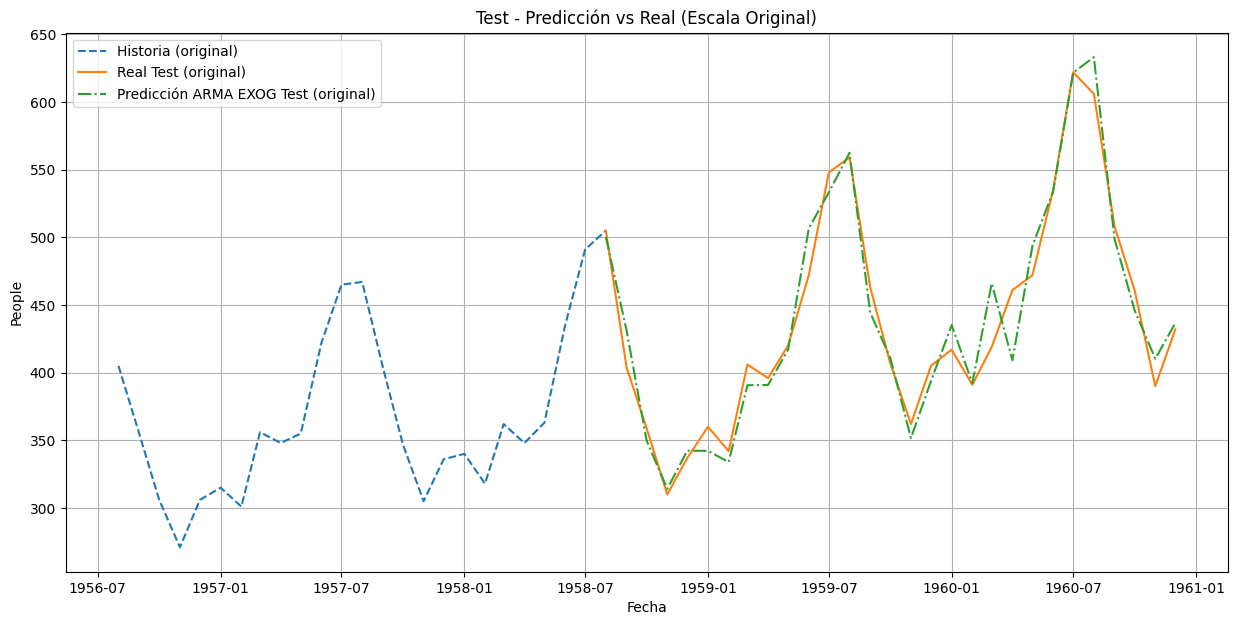

In [91]:
X_test_dum = X_test_dum.astype(int)
model_arma_preds = res_model_arma_exog.forecast(steps=len(y_test_dum), exog=X_test_dum)
pred_array_for_inversion = np.array(model_arma_preds.values)
true_array_for_inversion = np.array(y_test_dum)

pred_original_test, true_original_reconstructed_test = invert_transformations_corrected(
    y_transformed_pred_array=pred_array_for_inversion, 
    y_transformed_true_array=true_array_for_inversion, 
    prediction_datetime_index=X_test.index,
    original_full_log_series=df_log['People'],
    original_full_log_diff1_series=df_diffed['People'],
    seasonal_lag=12 
)


mape_original_test = mean_absolute_percentage_error(
    df.loc[X_test.index, 'People'],
    model_arma_preds
)
print(f'\nmape en fold 5 (escala original): {mape_original_test:.4f}')

plt.figure(figsize=(15, 7))
history_idx_end = X_test.index[0]
history_idx_start = history_idx_end - pd.DateOffset(months=24)

# Historia previa al test
plt.plot(df.loc[history_idx_start:history_idx_end, 'People'], label='Historia (original)', linestyle='--')

# Valores reales del test
plt.plot(df.loc[X_test.index, 'People'], label='Real Test (original)')

# Predicción en test
plt.plot(X_test.index, pred_original_test, label='Predicción ARMA EXOG Test (original)', linestyle='-.')

plt.title('Test - Predicción vs Real (Escala Original)')
plt.xlabel('Fecha')
plt.ylabel('People')
plt.legend()
plt.grid(True)
plt.show()